In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glove import Corpus, Glove
from konlpy.tag import Mecab

In [ ]:
df = pd.read_csv('./data/Textranked.csv')
df

,Question,Answer
0,정말 어려운 상황에서 너무나도 힘들어서 질문을 드립니다. 아버지가 제 명의로 사업자...,차량의 경우 현재 점유자인 아버지를 피고로 하여 차량 인도 청구소송 및 차량 점유 ...
1,년 전에 대포 통장이로 인해 피해를 봐서 재판 결과가 불기소 유통 지을 받았거든요....,소장 내용에 대한 검토가 필요하므로 소장을 지참하고 상담을 받으시기 바랍니다
2,제 계좌로 입금을 했다던가 그런부분 전혀없이 그 형의 계좌로 그 형의 공인인증서를 ...,별도의 구체적 상담이 필요하나 실제 채무가 없음에도 공증을 가지고 채권자가 강제집행...
3,채권시효년 소멸로 본다면 어떤 대응이 가능할지 여쭤봅니다 지인에게 연대보증 해줬는데...,별도의 구체적 상담이 필요하나 이행 권고 결정은 기판력의 제한이 없으므로 소멸시효 ...
4,그 와중에 피의자와 어떻게 연락이 닿게 되어서 갚겠다는 의사를 보였고 정말 적은 ...,가해자가 위 사건으로 구속 기소되었다면 가해자를 피고로 하여 민사소송 및 강제집행으...
...,...,...
18160,제가 작년 월쯤 승소 판결 받은 후에 압류 절차를 진행을 해야 하는데 혼자 스스로 ...,여쭤보신 것은 통장 압류 절차인 것으로 보입니다 통장 압류의 법률적 용어는 예금채...
18161,민사재판 패소 후 현재 등본은 부모님댁으로 되어있습니다,민사소송 패소 후 부모님 집에 압류가 들어올 수 있는지와 관련하여 질문하셨습니다.민...
18162,이에 원고인에게 원룸계약서 제출을 요구합니다 라고 썼거든요.거기보니 원고측에서 이미...,따라서 각 월 차임 채권은 년에 발생한 경우 년이 경과한 년 사이에 이미 시효...
18163,오늘 피고 측에서 답변서를 받고 변론 기일이 정해졌는데 이제 보니 제가 작성한 소...,민사소송 소장에 소송비용 청구를 빠드린 경우와 관련하여 질 무하셨습니다. 민사소송에...


In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [ ]:
mecab = Mecab()
q_pos = []

for i in range(len(df)):
    q_pos.append(mecab.pos(df['Question'][i]))
df['q_tokens'] = q_pos

pos = ["NNG","NNP","VV","VA"]

df['q_tokens'] = df['q_tokens'].apply(lambda x: [t for (t, p) in x if p in pos])

In [ ]:
df_q = df['q_tokens']

In [ ]:
corpus = Corpus()
corpus.fit(df_q, window=20)

In [ ]:
glove = Glove(no_components=128, learning_rate=0.01)
glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=False)
glove.add_dictionary(corpus.dictionary)

In [ ]:
word_dict = {}
for word in  glove.dictionary.keys():
    word_dict[word] = glove.word_vectors[glove.dictionary[word]]

In [ ]:
def sent2vec_glove(tokens, embedding_dim=128):
  
    size = len(tokens)
    matrix = np.zeros((size, embedding_dim))
    word_table = word_dict     # glove word_dict

    for i, token in enumerate(tokens):
        vector = np.array([
            word_table[t] for t in token
            if t in word_table
        ])

        if vector.size != 0:
            final_vector = np.mean(vector, axis=0)
            matrix[i] = final_vector

    return matrix

In [ ]:
sentence_glove = sent2vec_glove(df_q)

In [ ]:
sentence_glove.shape

(18165, 128)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


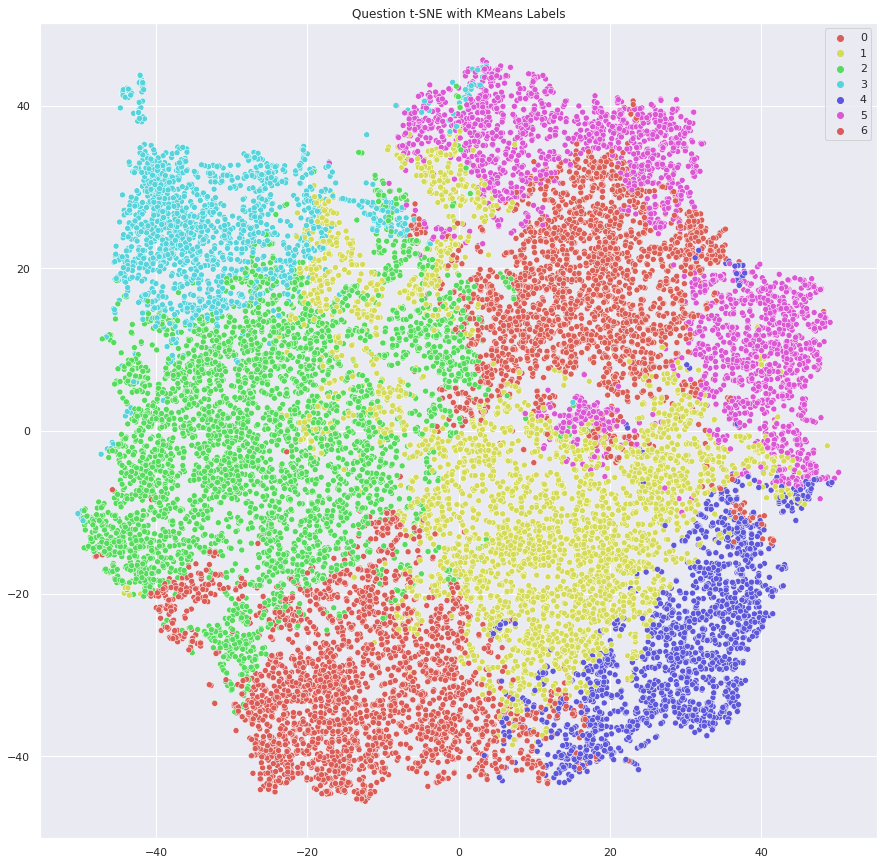

In [ ]:
k = 7
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(sentence_glove)

tsne = TSNE(n_components = 2, perplexity = 100)
X_embedded = tsne.fit_transform(sentence_glove)

sns.set(rc={'figure.figsize':(15,15)})
palette = sns.hls_palette("ch:s=.25,rot=-.25", as_cmap=True) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred,
                legend='full', palette=palette)

plt.title('Question t-SNE with KMeans Labels')
plt.show()